In [1]:
import input as inp
import alg as a
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import pandas as pd
import time
import random

In [3]:
# time interval is 10 minutes per t, total in 24 hours
t = 144

# time-of-use energy price.
origin = [0.3088,0.2208, 0.1738]
energyPlan = origin

Cidle = 1
Cpeak = 3

# turn on sever cost
Cs = 4

# energy unit price per t
pt = [0] * t
for i in range(t):
    if i < 49:
        pt[i] = energyPlan[2];
    elif i > 48 and i<55:
        pt[i] = energyPlan[0];
    elif i > 54 and i < 66:
        pt[i] = energyPlan[1];
    elif i > 65 and i < 84:
        pt[i] = energyPlan[0];
    elif i > 83 and i < 102:
        pt[i] = energyPlan[1];
    elif i > 101 and i < 126:
        pt[i] = energyPlan[0];
    else:
        pt[i] = energyPlan[2];

#server power consumpation
#bt = Cidle * Xsv + (Cpeak - Cidle) * Aw1

# workload to be served per t
Aw1 = [0]
for i in range(t):
    if i > 0:
        Aw1.append(random.randint(0, 1))
OPT1=0
xi = [1]*144
xi[0] = 0
for m in range(144):
    OPT1 += pt[m] * (Cidle*xi[m] + (Cpeak - Cidle) * Aw1[m])

In [23]:
w_list = np.arange(0,1,.1)
repeat = 50
alg_reps = 100
c_ratio = np.zeros((len(w_list), repeat))
for idx,w in enumerate(w_list):
    for j in np.arange(repeat):
        ins = inp.Instance(B=4,time_dependant=True,predictor_std=0)
        alg_total = 0
        for l in range(alg_reps):
            alg_total += a.RPOA(ins, w)
        opt = a.OPT(ins)
        alg_avg = alg_total/alg_reps
        c_ratio[idx, j] = alg_avg/opt
avg_ratio2 = np.mean(c_ratio, axis=1)




[1.40725    1.4063     1.42813333 1.45621667 1.33471667 1.28215
 1.21326667 1.15111667 1.12       1.13      ]


In [22]:
w_list = np.arange(0,1.1,.1)
repeat = 1000
c_ratio = np.zeros((len(w_list), repeat))
for idx,w in enumerate(w_list):
    for j in np.arange(repeat):
        ins = inp.Instance(B=4,time_dependant=True,predictor_std=0)
        alg = a.DPOA(ins, w)
        opt = a.OPT(ins)
        c_ratio[idx, j] = alg/opt
avg_ratio1 = np.mean(c_ratio, axis=1)


[1.44    1.432   1.424   1.423   1.42075 1.2715  1.281   1.29    1.14075
 1.1415  1.     ]


In [16]:
# total cost to operate the datacenter
DPOA = 0
RPOA = 0
OPT = 0

repeat = 10
instance = 100
w_list = np.arange(0,1,.1)
plot_DPOA = []
plot_RPOA = []
# std = 0
std_list = np.arange(0,22,2)

for idx,w in enumerate(w_list):
    plot_1 = []
    plot_2 = []
    for m in range(repeat):
        for i in range(instance):
            ins = inp.Instance(w, B=Cs, time_dependant=False,predictor_std=0)
            energyCost_DPOA = 0
            switchCost_DPOA = 0
            totalCoST_DPOA = 0
            Xsv_DPOA = [0]
            status_DPOA = 1
            i0 = 0
            for i in range(t-1):
                if Aw1[i] == 1:
                    i0 = i
                    status_DPOA = 1
                    Xsv_DPOA.append(1)
                    energyCost_DPOA += pt[i] * (Cidle + (Cpeak - Cidle) * Aw1[i])
                else:
                    buy = a.DPOA_eval(ins,w)
                    if buy:
                        if status_DPOA == 0:
                            Xsv_DPOA.append(0)
                            continue
                        Xsv_DPOA.append(0)
                        status_DPOA = 0
                        switchCost_DPOA += Cs
                        energyCost_DPOA += 0
                    else:
                        Xsv_DPOA.append(1)
                        status_DPOA = 1
                        switchCost_DPOA += 0
                        energyCost_DPOA += pt[i] * (Cidle + (Cpeak - Cidle) * Aw1[i])
            totalCost_DPOA = energyCost_DPOA + switchCost_DPOA
            
            energyCost_RPOA = 0
            switchCost_RPOA = 0
            totalCoST_RPOA = 0
            status_RPOA = 1
            Xsv_RPOA= [0]
            i0=0
            for i in range(t-1):
                # buy or rent
                if Aw1[i] == 1:
                    status_RPOA = 1
                    Xsv_RPOA.append(1)
                    energyCost_RPOA += pt[i] * (Cidle + (Cpeak - Cidle) * Aw1[i])
                else:
                    buy = a.RPOA_eval(ins,w)
                    if buy:
                        if status_RPOA == 0:
                            Xsv_RPOA.append(0)
                            continue
                        Xsv_RPOA.append(0)
                        status_RPOA = 0
                        switchCost_RPOA += Cs
                        energyCost_RPOA += 0
                    else:
                        Xsv_RPOA.append(1)
                        status_RPOA = 1
                        switchCost_RPOA += 0
                        energyCost_RPOA += pt[i] * (Cidle + (Cpeak - Cidle) * Aw1[i])
            totalCost_RPOA = energyCost_RPOA + switchCost_RPOA

            energyCost_opt = 0
            switchCost_opt = 0
            totalCoST_opt = 0
            Xsv_opt= [0]
            temp = 0
            count = 0
            temp_energyCost = 0
            switch = 0
            for i in range(len(Aw1)):
                if Aw1[i] == 1:
                    temp = 0
                    count = 0
                    temp_energyCost = 0
                    switch = 0
                    Xsv_opt.append(1)
                    energyCost_opt += pt[i] * (Cidle + (Cpeak - Cidle) * Aw1[i])
                else:
                    temp += Cidle
                    count += 1
                    if temp > Cs:
                        switch = 1
                    else:
                        temp_energyCost += pt[i] * Cidle  
                    if i < len(Aw1) - 1 and Aw1[i+1] == 1:
                        if switch == 1:
                            switchCost_opt += Cs
                            for i in range(count): 
                                Xsv_opt.append(0)
                        else:
                            for i in range(count): 
                                Xsv_opt.append(1)
                            energyCost_opt += temp_energyCost
            totalCoST_opt = energyCost_opt + switchCost_opt

            DPOA += totalCost_DPOA
            RPOA += totalCost_RPOA
            OPT += OPT1
        _DPOA = DPOA / OPT
        _RPOA = RPOA / OPT
        plot_1.append(_DPOA)
        plot_2.append(_RPOA)
    plot_DPOA.append(np.mean(plot_1))
    plot_RPOA.append(np.mean(plot_2))


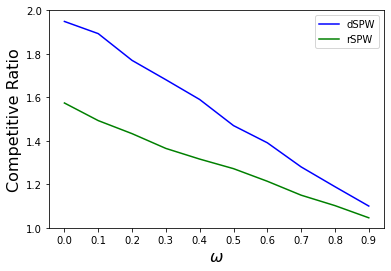

In [17]:
w_list = np.arange(0,1,0.1)
plot_DPOA = [1.949, 1.893, 1.770, 1.681, 1.590, 1.470, 1.391,1.280 , 1.189, 1.100]
plot_RPOA = [1.574, 1.493, 1.433, 1.365, 1.316, 1.272, 1.214,1.150, 1.102, 1.046]
plt.clf()
plt.plot(plot_DPOA,label="dSPW", color='b')
plt.plot(plot_RPOA,label="rSPW", color='g')

plt.legend(loc='upper right')
plt.xlabel("$\omega$", fontsize=16)
plt.ylabel("Competitive Ratio", fontsize=16)
formated_list = ['%.1f' % elem for elem in w_list]
plt.xticks(np.arange(10), formated_list)
plt.ylim(1.0,2.0)
# plt.savefig("datacenter", dpi=1000)

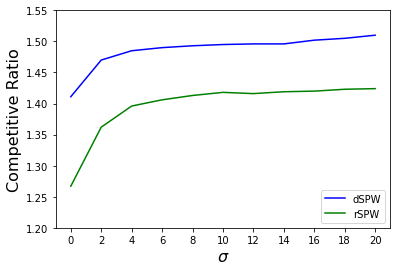

In [13]:
std_list = np.arange(0,22,2)
w = 0.5
plot_DPOA = [1.411, 1.470,1.485,1.490,1.493,1.495,1.496,1.496,1.502,1.505,1.510]
plot_RPOA = [1.267,1.362,1.396,1.406,1.413,1.418,1.416,1.419,1.420,1.423,1.424]
plt.clf()
plt.plot(plot_DPOA,label="dSPW", color='b')
plt.plot(plot_RPOA,label="rSPW", color='g')

plt.legend(loc='lower right')
plt.xlabel("$\sigma$", fontsize=16)
plt.ylabel("Competitive Ratio", fontsize=16)
formated_list = [elem for elem in std_list]
plt.xticks(np.arange(11), std_list)
plt.ylim(1.20,1.55)
# plt.savefig("datacenter1", dpi=1000)

array([0])